# Kalman Filter for LUNA Modelling

## Explanation

In order to predict drop out, we can start by estimating an underlying latent variable ("intent to drop out"). My Understanding is, that this is mostly measured by the PANNP (etc) items. We can map these items into a latent space using the loadings found via CFA. With these, we can then measure and predict the "intent to drop out".

### Assumption: The loadings do infact measure this latent factor! We need to check this!

## Usage

See below for an example. The model at this point only runs on a per-person basis. 

## Next steps

1. Get this running on real data
2. Deploy
3. We can probably extend this into a type of multi-level model, by passing all students in a class, with a given covariance structure.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format='retina'
matplotlib.rcParams['figure.figsize'] = (15, 7)

In [70]:
class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0
        self.predictions = np.array([])

    def predict(self, u = 0):
        self.x = self.F @ self.x + self.B + u
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.x, self.P

    def update(self, z):
        y = z - self.H @ self.x
        S = self.R + self.H @ self.P @ self.H.T
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        I = np.eye(self.n)
        self.P = (I - K @ self.H) @ self.P @ (I - K @ self.H).T + K @ self.R @ K.T

    def forward(self, observations):
        # Runs the forward algorithm based on observations
        self.predictions_state = []
        self.predictions_obs = []
        self.predictions_cov = []

        for z in observations.T:
            z = z.reshape(3,1)
            self.predictions_obs.append(H @ self.predict()[0])
            self.predictions_state.append(self.predict()[0])
            self.predictions_cov.append(self.predict()[1])
            self.update(z)
        
        return self.predictions_state, self.predictions_cov, self.predictions_obs
    
    def rts_smoother(self, x_filt, P_filt):
        n, dim_x, _ = x_filt.shape   
        # RTS smoother gain
        K = np.zeros((n,dim_x,dim_x))
        x_smooth = np.zeros((n,dim_x,1))
        P_smooth = np.zeros((n,dim_x,dim_x))

        x_smooth[-1] = x_filt[-1]
        P_smooth[-1] = P_filt[-1]

        for k in range(n-2,-1,-1):
            P_pred = np.dot(np.dot(self.F, P_filt[k]), self.F.T) + self.Q

            K[k]  = np.dot(np.dot(P_filt[k], self.F.T), np.linalg.inv(P_pred))
            x_smooth[k] = x_filt[k] + np.dot(K[k], x_smooth[k+1] - np.dot(self.F, x_filt[k]))
            P_smooth[k] = P_filt[k] + np.dot(np.dot(K[k], P_smooth[k+1] - P_pred), K[k].T)
        
        return x_smooth, P_smooth, K

## Example Usage

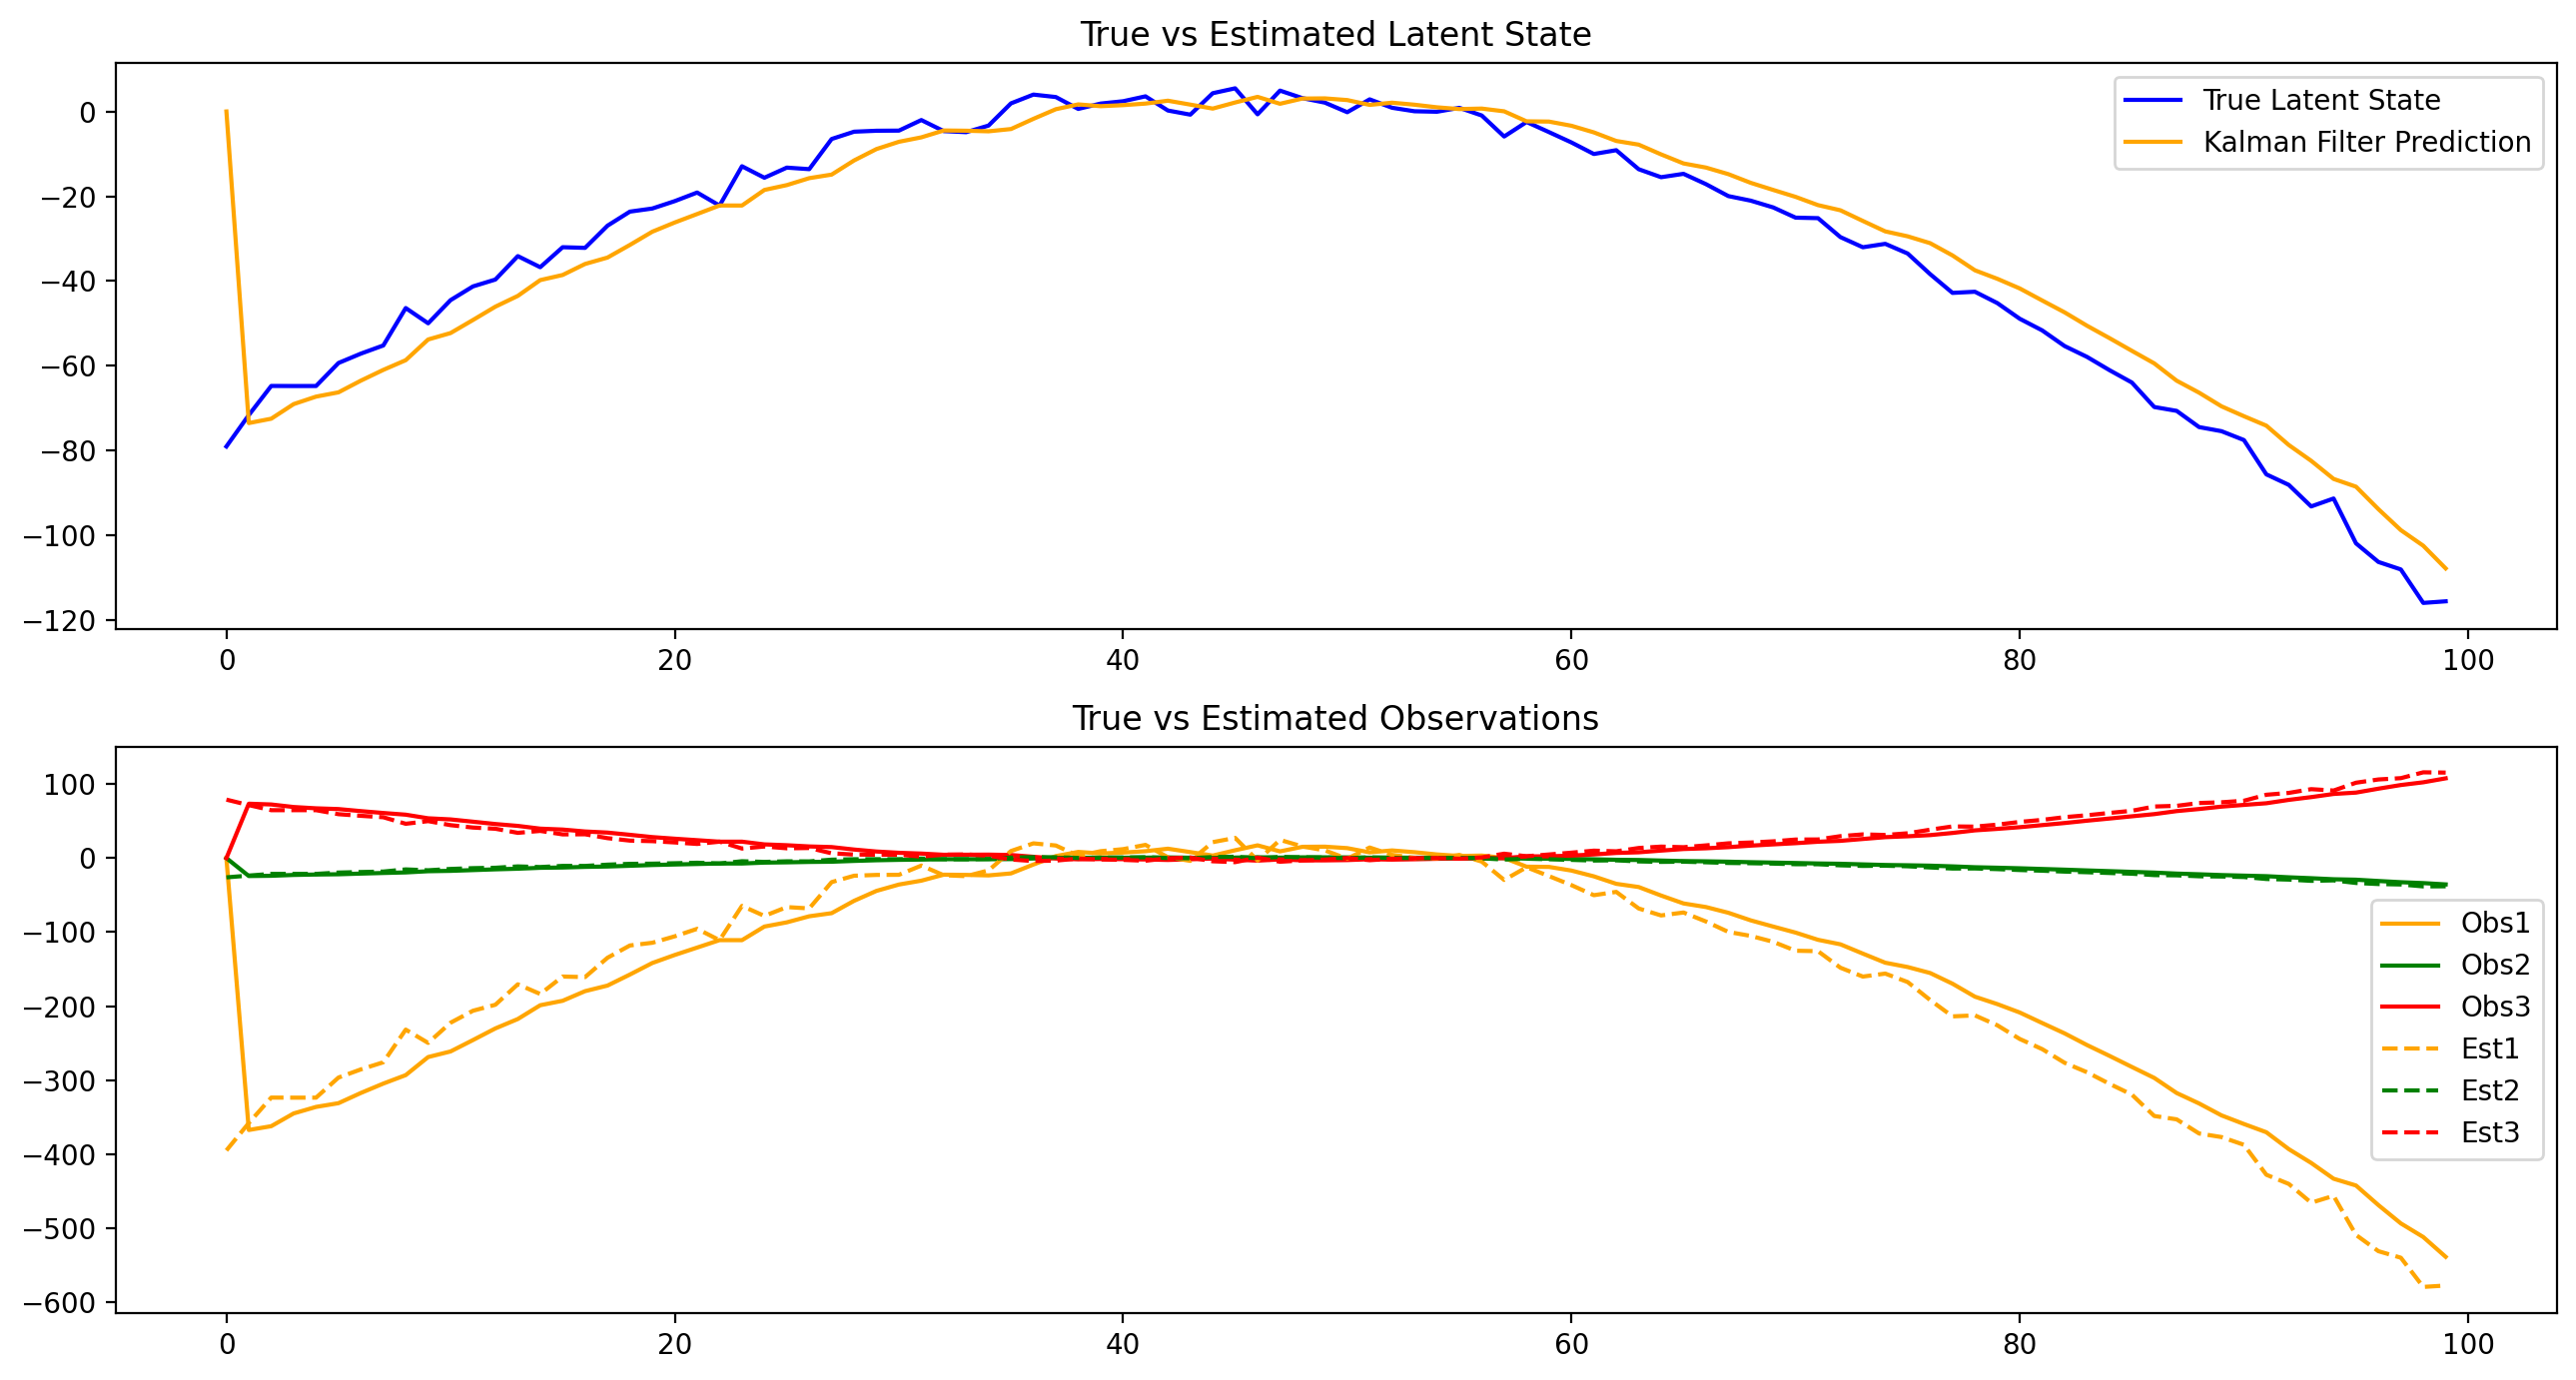

In [5]:
F = np.array([[1]])  # Assuming no change in state

H = np.array([[5],  # First observation directly maps to the state
              [0.33],  # Second observation directly maps to the state
              [-1]]) # Third observation directly maps to the state

Q = np.array([[0.01]])  # Adjust the value as per your system dynamics and noise characteristics

R = np.array([[2, 0, 0],  # Covariance of the first observation
              [0, 2, 0],  # Covariance of the second observation
              [0, 0, 2]]) # Covariance of the third observation
x0 = np.array([[0]])  # Initial state estimate


x = np.linspace(-10, 10, 100)
latent_state = (- (x**2 + 2*x - 2)  + np.random.normal(0, 2, 100)).reshape(1,100)
observations = H @ latent_state

kf = KalmanFilter(F = F, H = H, Q = Q, R = R, x0 = x0)
predictions_state, predictions_obs = kf.forward(observations)

# Assuming predictions_obs, observations, latent_state, and predictions are defined

# Create a figure and two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 7))

# Plotting the true latent state and Kalman filter predictions on the first subplot (ax1)
ax1.plot(range(len(latent_state.T)), latent_state.T, label='True Latent State', color='blue')
ax1.plot(range(len(predictions_state)), np.array(predictions_state).flatten(), label='Kalman Filter Prediction', color='orange')
ax1.set_title("True vs Estimated Latent State")
ax1.legend()

# Plotting observations and estimates on the second subplot (ax2)
colors = ['orange', 'green', 'red']

# Plotting observations
for i in range(3):
    ax2.plot(np.array(predictions_obs).reshape(100, 3)[:, i], label=f"Obs{i+1}", color=colors[i])

# Plotting estimates
for i in range(3):
    ax2.plot(observations[i], label=f"Est{i+1}", linestyle="--", color=colors[i])

ax2.legend()
ax2.set_title("True vs Estimated Observations")
# Adjusting layout to prevent overlapping
plt.tight_layout()

plt.show()


## Another Example

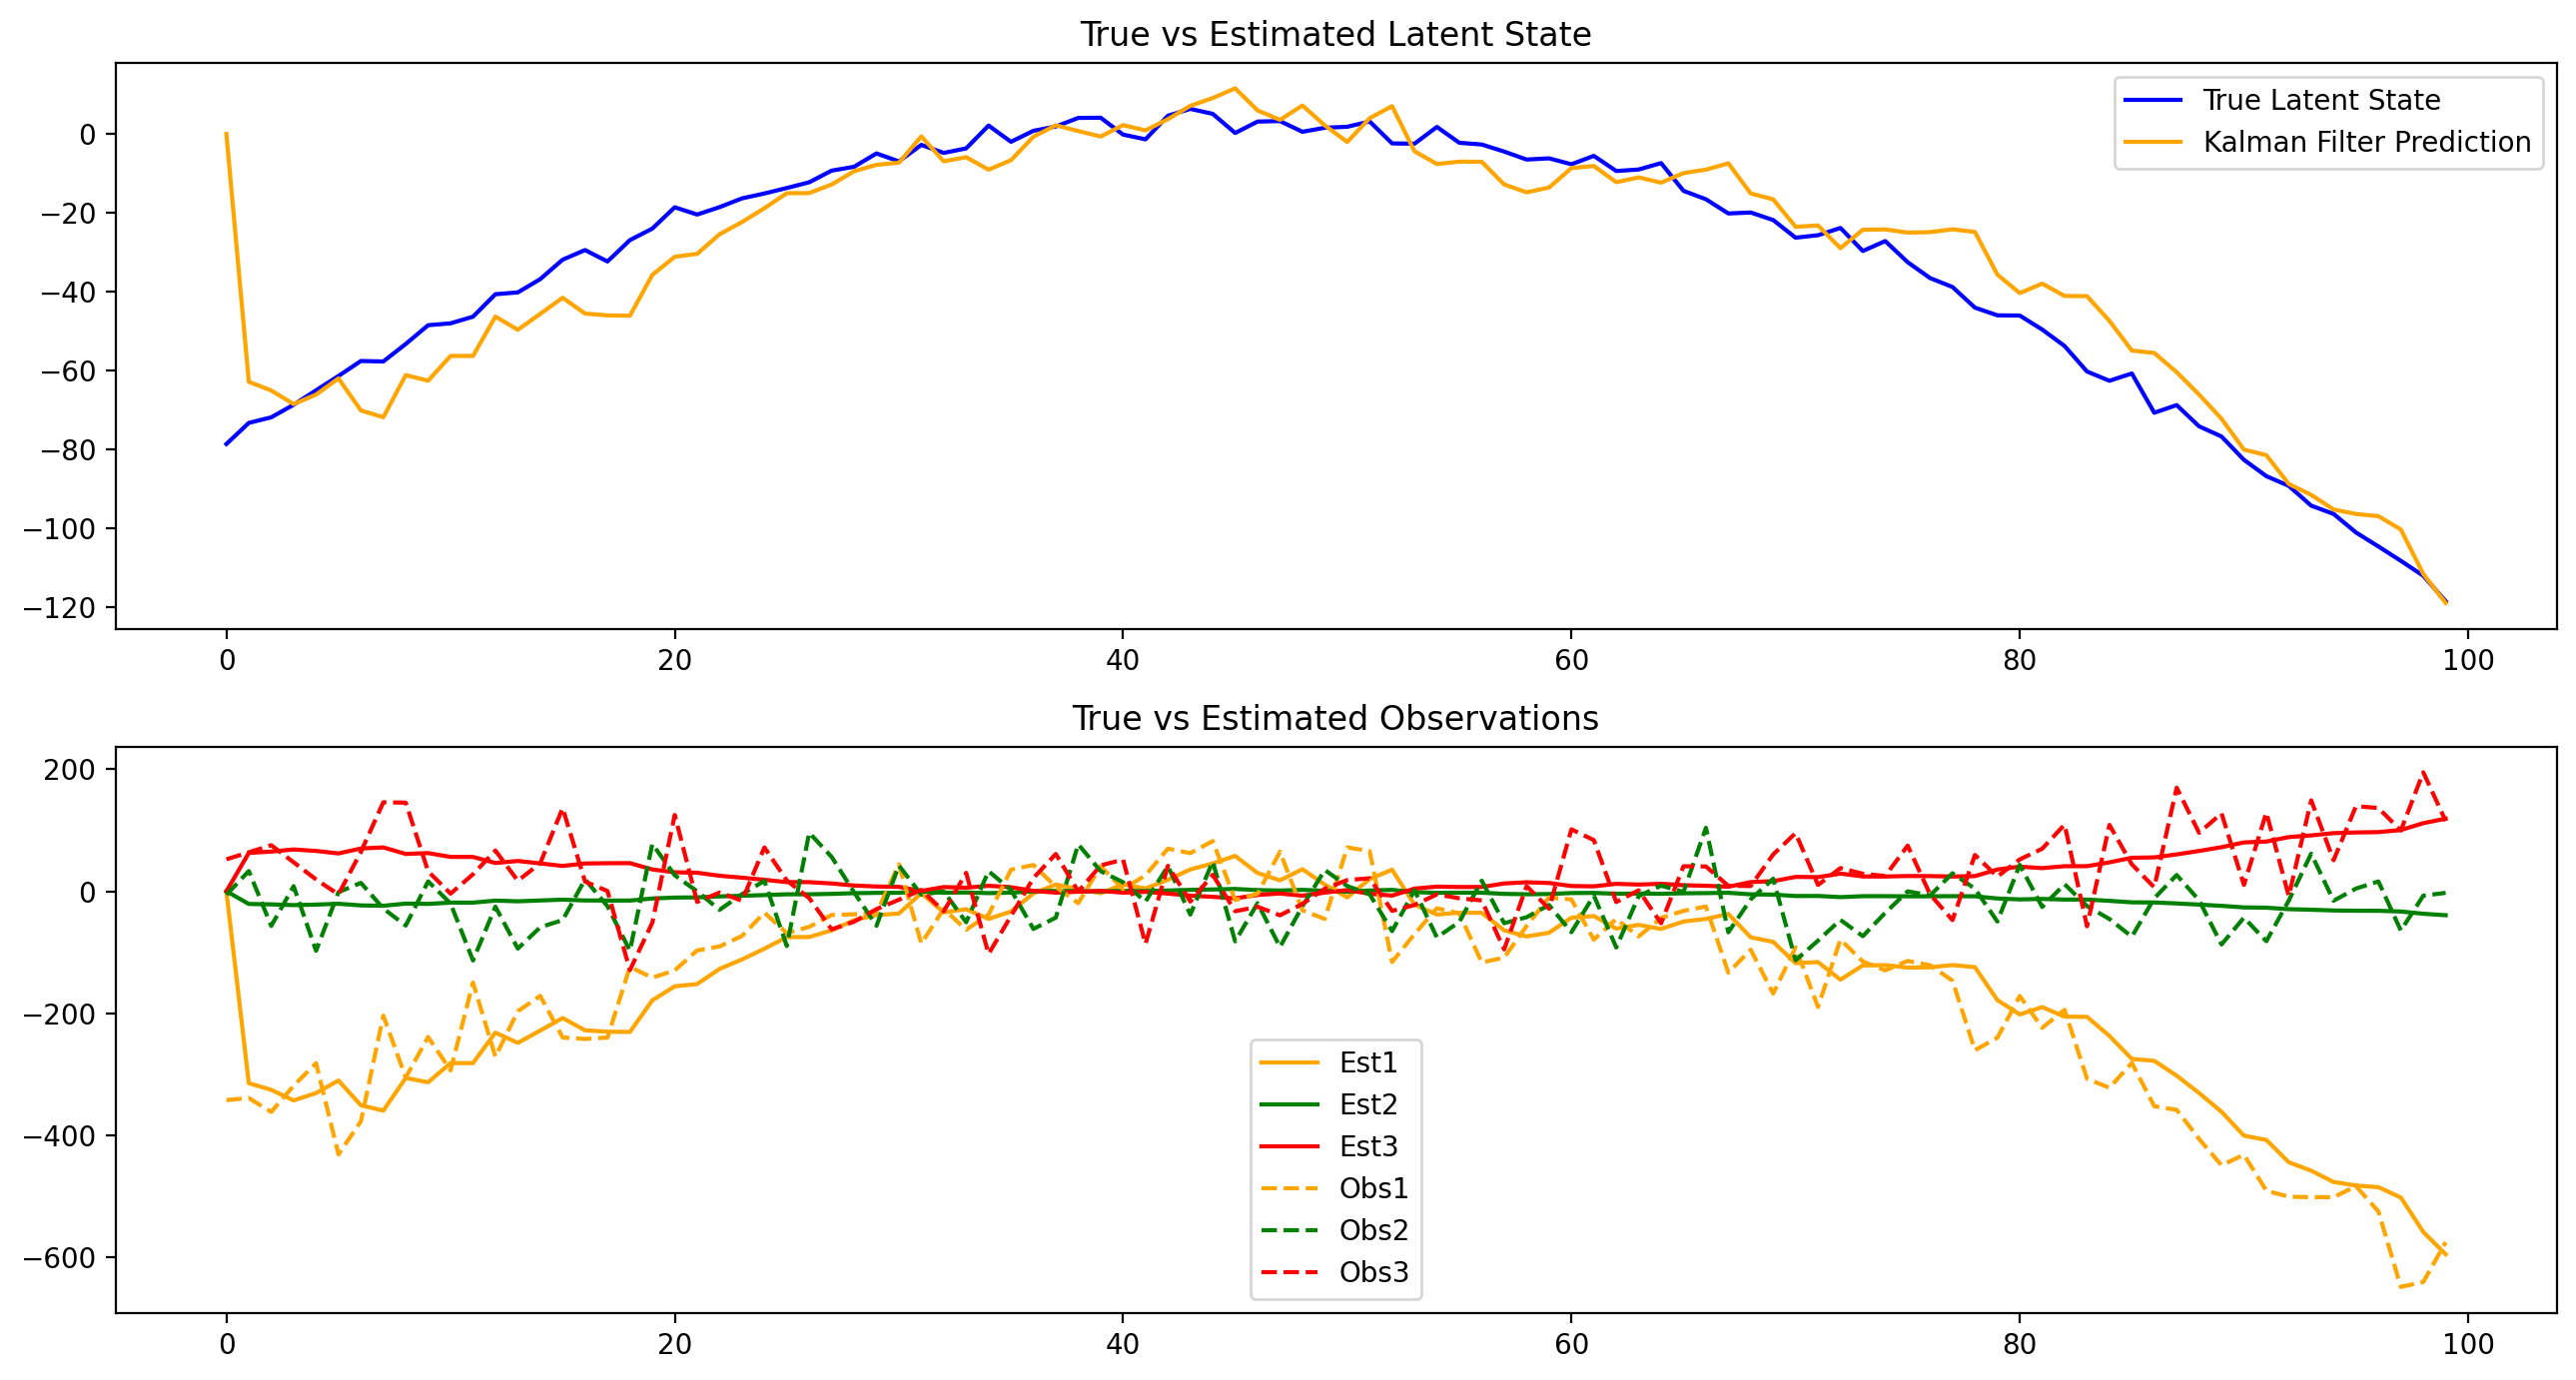

In [6]:
F = np.array([[1]])  # Assuming no change in state

H = np.array([[5],  # First observation directly maps to the state
              [0.33],  # Second observation directly maps to the state
              [-1]]) # Third observation directly maps to the state

Q = np.array([[0.01]])  # Adjust the value as per your system dynamics and noise characteristics

R = np.array([[2, 0, 0],  # Covariance of the first observation
              [0, 2, 0],  # Covariance of the second observation
              [0, 0, 2]]) # Covariance of the third observation
x0 = np.array([[0]])  # Initial state estimate


x = np.linspace(-10, 10, 100)
latent_state = (- (x**2 + 2*x - 2)  + np.random.normal(0, 2, 100)).reshape(1,100)
observations = H @ latent_state + np.random.normal(0,50,300).reshape(3,100)



kf = KalmanFilter(F = F, H = H, Q = Q, R = R, x0 = x0)
predictions_state, predictions_obs = kf.forward(observations)


# Assuming predictions_obs, observations, latent_state, and predictions are defined

# Create a figure and two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 7))

# Plotting the true latent state and Kalman filter predictions on the first subplot (ax1)
ax1.plot(range(len(latent_state.T)), latent_state.T, label='True Latent State', color='blue')
ax1.plot(range(len(predictions_state)), np.array(predictions_state).reshape(100,1), label='Kalman Filter Prediction', color='orange')
ax1.set_title("True vs Estimated Latent State")
ax1.legend()

# Plotting observations and estimates on the second subplot (ax2)
colors = ['orange', 'green', 'red']

# Plotting observations
for i in range(3):
    ax2.plot(np.array(predictions_obs).reshape(100, 3)[:, i], label=f"Est{i+1}", color=colors[i])

# Plotting estimates
for i in range(3):
    ax2.plot(observations[i], label=f"Obs{i+1}", linestyle="--", color=colors[i])

ax2.legend()
ax2.set_title("True vs Estimated Observations")
# Adjusting layout to prevent overlapping
plt.tight_layout()

plt.show()


## KF on real Data

In [4]:
#data preperation
#tx = pd.read_csv("tx_long.csv")
tx = pd.read_csv("./data/data_scales/TX/tx_long.csv")
pivoted = tx.pivot(index='studentID',columns='meas',values=['PANN01_state','PANN05_state','PANN09_state'])

# Should forward fill these I think. Or drop from analysis?
PANN01_state = pivoted['PANN01_state'].T
PANN05_state = pivoted['PANN05_state'].T
PANN09_state = pivoted['PANN09_state'].T



Y1 = PANN01_state.to_numpy()
Y2 = PANN05_state.to_numpy()
Y3 = PANN09_state.to_numpy()
Y = np.stack((Y1,Y2,Y3),axis=2) #axis=0 would lead to (3, 50, 117)
Y = np.transpose(Y,(1,2,0))
Y.shape

# For getting factor loadings we need the dataset filled. 
# Here we interpolate, forwardfill and backfill the remaining values.
# This isn't super clean, but it at least gets it running. Smarter interpolation / calculation of factor loadings can be done later.w
PANN01_state = pivoted['PANN01_state'].interpolate(axis=1).ffill().bfill().T
PANN05_state = pivoted['PANN05_state'].interpolate(axis=1).ffill().bfill().T
PANN09_state = pivoted['PANN09_state'].interpolate(axis=1).ffill().bfill().T
Y1 = PANN01_state.to_numpy()
Y2 = PANN05_state.to_numpy()
Y3 = PANN09_state.to_numpy()
Y_factors = np.stack((Y1,Y2,Y3),axis=2) #axis=0 would lead to (3, 50, 117)
#Y_factors = np.transpose(Y,(1,2,0))
Y_factors.shape


(50, 117, 3)

In [5]:
Y.shape

(117, 3, 50)

#### Factor Loadings

In [6]:
from sklearn.decomposition import FactorAnalysis

In [7]:
transformer = FactorAnalysis(n_components=1, random_state=0)
fit = transformer.fit(Y_factors.reshape(-1,3))
fit.components_.reshape(-1,1)

array([[1.02584791],
       [1.20147747],
       [1.0151294 ]])

In [8]:
H = fit.components_.reshape(-1,1) * 2

In [9]:
H.shape

(3, 1)

#### The rest

Idea: We have a mean and covariance, so we can use the Normal Distribution over the both as a best guess for the missing values. 

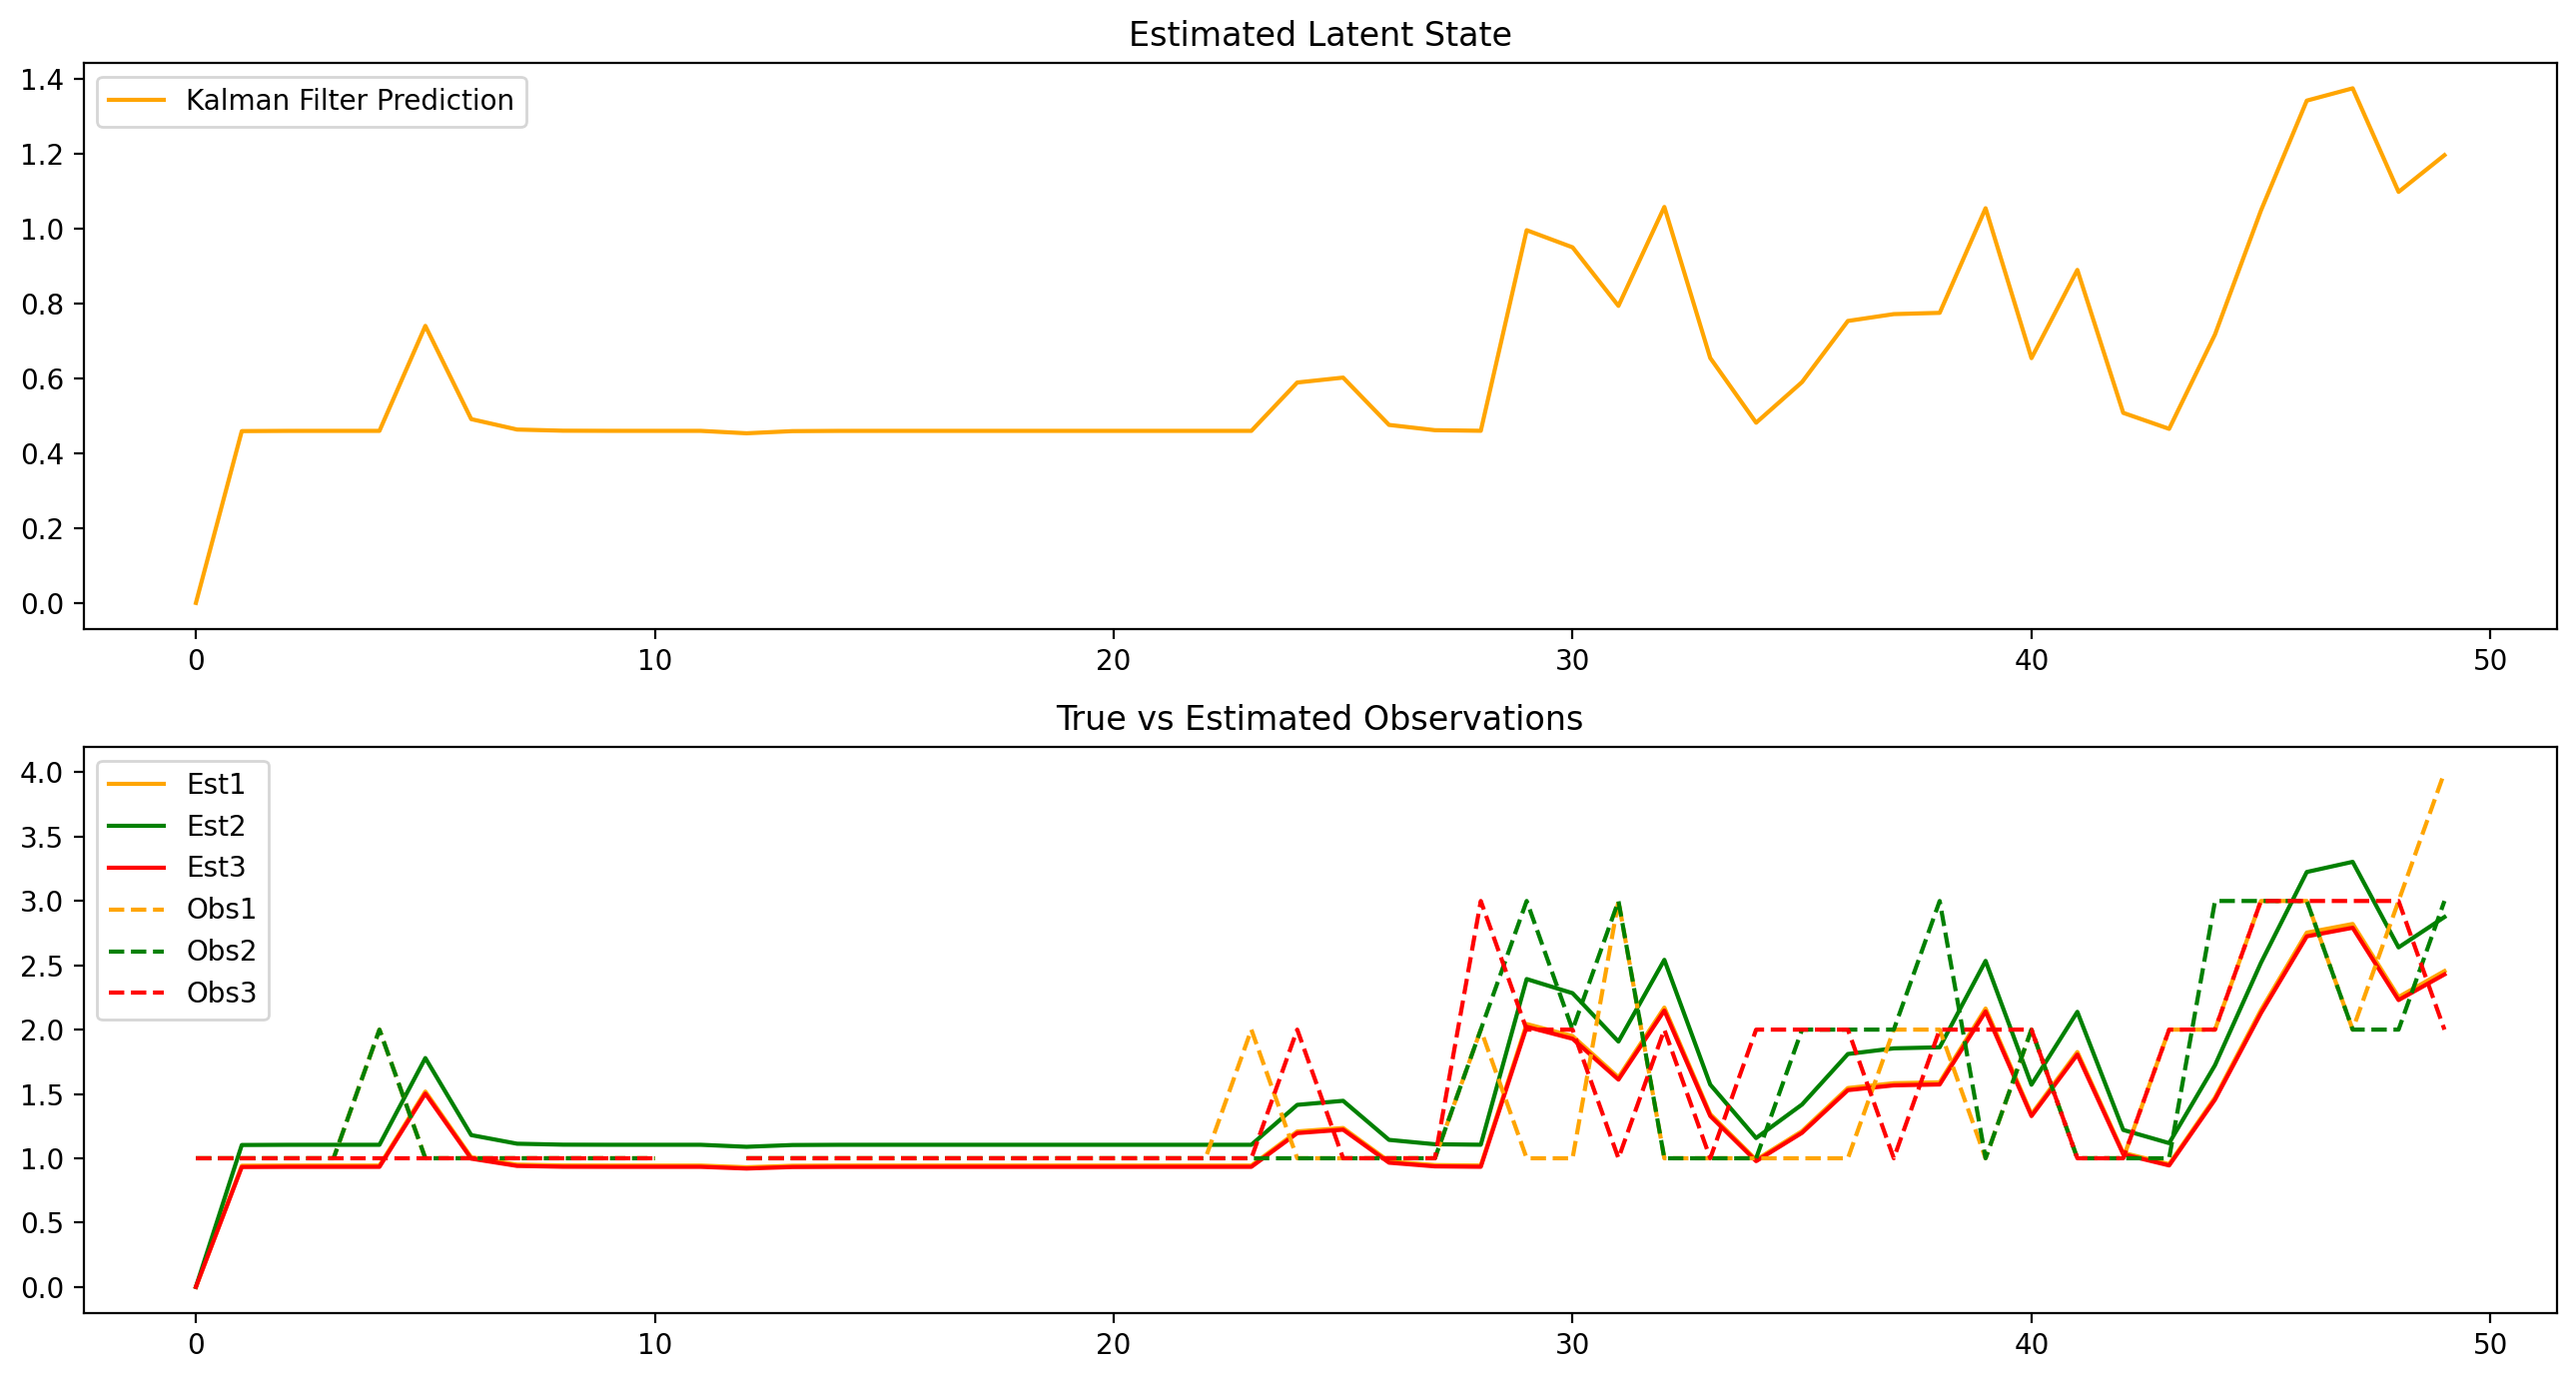

In [11]:
STUDENT = 2

F = np.array([[1]])  # Assuming no change in state


Q = np.array([[0.01]])  # Adjust the value as per your system dynamics and noise characteristics

R = np.array([[2, 0, 0],  # Covariance of the first observation
              [0, 2, 0],  # Covariance of the second observation
              [0, 0, 2]])*0.01 # Covariance of the third observation
x0 = np.array([[0]])  # Initial state estimate


observations = Y[STUDENT,:,:].T


kf = KalmanFilter(F = F, H = H, Q = Q, R = R, x0 = x0)
predictions_state = []
predictions_obs = []
predictions_cov = []

for z in observations:
    z = z.reshape(3,1)
    if np.isnan(z).any():# all the missing values
        if not predictions_state: #if predictions are empty, meaning that the first observation is empty i.e. the first value is nan, set z to 1,1,1
            z = np.array([2,2,2]).reshape(3,1)
        else:
            expected_mean = np.random.normal(predictions_state[-1],predictions_cov[-1]) # sampling from the last observed step
            z = H @ expected_mean #from latent to observed state
    
    predictions_dummy,prediction_dummy_cov = kf.predict()
    predictions_obs.append(H @ predictions_dummy)
    predictions_state.append(predictions_dummy)
    predictions_cov.append(prediction_dummy_cov)
    kf.update(z)


# Create a figure and two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 7))

# Plotting the true latent state and Kalman filter predictions on the first subplot (ax1)
ax1.plot(range(len(predictions_state)), np.array(predictions_state).reshape(len(observations),1), label='Kalman Filter Prediction', color='orange')
ax1.set_title("Estimated Latent State")
ax1.legend()

# Plotting observations and estimates on the second subplot (ax2)
colors = ['orange', 'green', 'red']

# Plotting observations
for i in range(3):
    ax2.plot(np.array(predictions_obs).reshape(len(observations), 3)[:, i], label=f"Est{i+1}", color=colors[i])

# Plotting estimates
for i in range(3):
    ax2.plot(observations[:,i], label=f"Obs{i+1}", linestyle="--", color=colors[i])

ax2.legend()
ax2.set_title("True vs Estimated Observations")
# Adjusting layout to prevent overlapping
plt.tight_layout()

plt.show()

## Smoother (still work in progress)

In [21]:
T = 10
inity = np.array([4,5])
y = np.zeros(T)

y[:len(inity)] = inity
K = np.array([0.4,0.3])

for t in range(T-len(inity)):
    t = t + len(inity)
    idx = list(range(t-len(inity),t))
    print(idx)
    
    y[t] = K @ y[idx]
y

[0, 1]
[1, 2]
[2, 3]
[3, 4]
[4, 5]
[5, 6]
[6, 7]
[7, 8]


array([4.        , 5.        , 3.1       , 2.93      , 2.119     ,
       1.8077    , 1.38991   , 1.140053  , 0.8979799 , 0.72541517])

In [22]:
def kalman_smoother(state_estimates, state_covariances, A):
    """
    Kalman smoother implementation for refining state estimates.

    Parameters:
    - state_estimates: Array of estimated latent states (shape: (1, T))
    - state_covariances: Array of state covariance matrices (shape: (1, 1, T))
    - A: State transition matrix (shape: (1, 1))

    Returns:
    - smoothed_state_estimates: Array of smoothed latent states (shape: (1, T))
    """

    T = state_estimates.shape[1]

    smoothed_state_estimates = np.zeros((1, T))

    # Initialization
    smoothed_state_estimates[:, -1] = state_estimates[:, -1]

    for t in range(T-2, -1, -1):
        # Smoothing step
        smoothed_state_estimates[:, t] = state_estimates[:, t] + \
                                         state_covariances[:, :, t] @ A.T @ \
                                         np.linalg.inv(state_covariances[:, :, t+1]) @ \
                                         (smoothed_state_estimates[:, t+1] - A @ state_estimates[:, t+1])

    return smoothed_state_estimates


First try of the Rauch–Tung–Striebel Smoother (Fixed Step size). As far as I understand it, we call the function every time we get a new observation and smooth all predictions of the latent state backwards. Hence we should do it recursibley over all observations.

In [23]:

def RTS_smoother(F, x_est, P_est):
    """
    Rauch–Tung–Striebel (RTS) smoother for state estimation.

    Parameters:
        F: numpy array
            State transition matrix.
        x_est: numpy array
            Estimated state vector.
        P_est: numpy array
            Estimated state covariance matrix.

    Returns:
        smoothed_states: numpy array
            Smoothed state estimates.
        smoothed_covariances: numpy array
            Smoothed state covariances.
    """

    # Number of time steps
    T = x_est.shape[0]

    # Initialize smoothed states and covariances
    smoothed_states = np.zeros_like(x_est)
    smoothed_covariances = np.zeros_like(P_est)

    # Initialize the RTS recursion
    x_hat = x_est[-1]
    P_hat = P_est[-1]

    # Perform RTS recursion backwards in time
    for t in range(T - 1, 2, -1):
        # Smoothing gain
        K = P_est[t-1] @ F.T @ np.linalg.inv(P_est[t])

        # Updated state and covariance
        x_hat = x_est[t] + K @ (x_hat - @ x_est[t])
        P_hat = P_est[t] + K @ (P_hat - @ P_est[t])

        # Store smoothed state and covariance (used for the next iterative step)
        smoothed_states[t] = x_hat
        smoothed_covariances[t] = P_hat

    return smoothed_states, smoothed_covariances

SyntaxError: invalid syntax (1751504238.py, line 37)

There are several types of smoothing filters and the smoother invented by Rauch, Tung, and Striebel is the most efficient one because of its ease of implementation and efficiency of computation. It is also called RTS smoother. ([Reference](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/13-Smoothing.ipynb))  

## smoother on real data

In [81]:
STUDENT = 2

F = np.array([[1]])  # Assuming no change in state
Q = np.array([[0.01]])  # Adjust the value as per your system dynamics and noise characteristics
R = np.array([[2, 0, 0],  # Covariance of the first observation
              [0, 2, 0],  # Covariance of the second observation
              [0, 0, 2]])*0.02 # Covariance of the third observation
x0 = np.array([[0]])  # Initial state estimate


observations = Y[STUDENT,:,:].T


kf = KalmanFilter(F = F, H = H, Q = Q, R = R, x0 = x0)
x_filt, P_filt, obs_filt = kf.forward(observations.T)

obs_filt[0]


array([[0.],
       [0.],
       [0.]])

In [71]:
STUDENT = 2

F = np.array([[1]])  # Assuming no change in state
Q = np.array([[0.01]])  # Adjust the value as per your system dynamics and noise characteristics
R = np.array([[2, 0, 0],  # Covariance of the first observation
              [0, 2, 0],  # Covariance of the second observation
              [0, 0, 2]])*0.02 # Covariance of the third observation
x0 = np.array([[0]])  # Initial state estimate


observations = Y[STUDENT,:,:].T


kf = KalmanFilter(F = F, H = H, Q = Q, R = R, x0 = x0)
x_filt, P_filt, obs_filt = kf.forward(observations.T)

# Run the RTS smoother on the filtered estimates and get the smoothed state estimates and their covariances
x_smooth, P_smooth, K = kf.rts_smoother(x_filt, P_filt)

# Create a figure and two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 7))

# Plotting the smoothed state estimates and Kalman filter predictions on the first subplot (ax1)
ax1.plot(range(len(x_smooth)), x_smooth.reshape(len(observations),1), label='RTS Smoother Prediction', color='blue')
ax1.plot(range(len(predictions_state)), np.array(predictions_state).reshape(len(observations),1), label='Kalman Filter Prediction', color='orange')
ax1.set_title("Estimated Latent State")
ax1.legend()

# Plotting observations and estimates on the second subplot (ax2)
colors = ['orange', 'green', 'red']

# Plotting observations
for i in range(3):
    ax2.plot(np.array(obs_filt).reshape(len(observations), 3)[:, i], label=f"Est{i+1}", color=colors[i])

# Plotting estimates
for i in range(3):
    ax2.plot(observations[i], label=f"Obs{i+1}", linestyle="--", color=colors[i])

ax2.legend()
ax2.set_title("True vs Estimated Observations")
# Adjusting layout to prevent overlapping
plt.tight_layout()

plt.show()





AttributeError: 'list' object has no attribute 'shape'

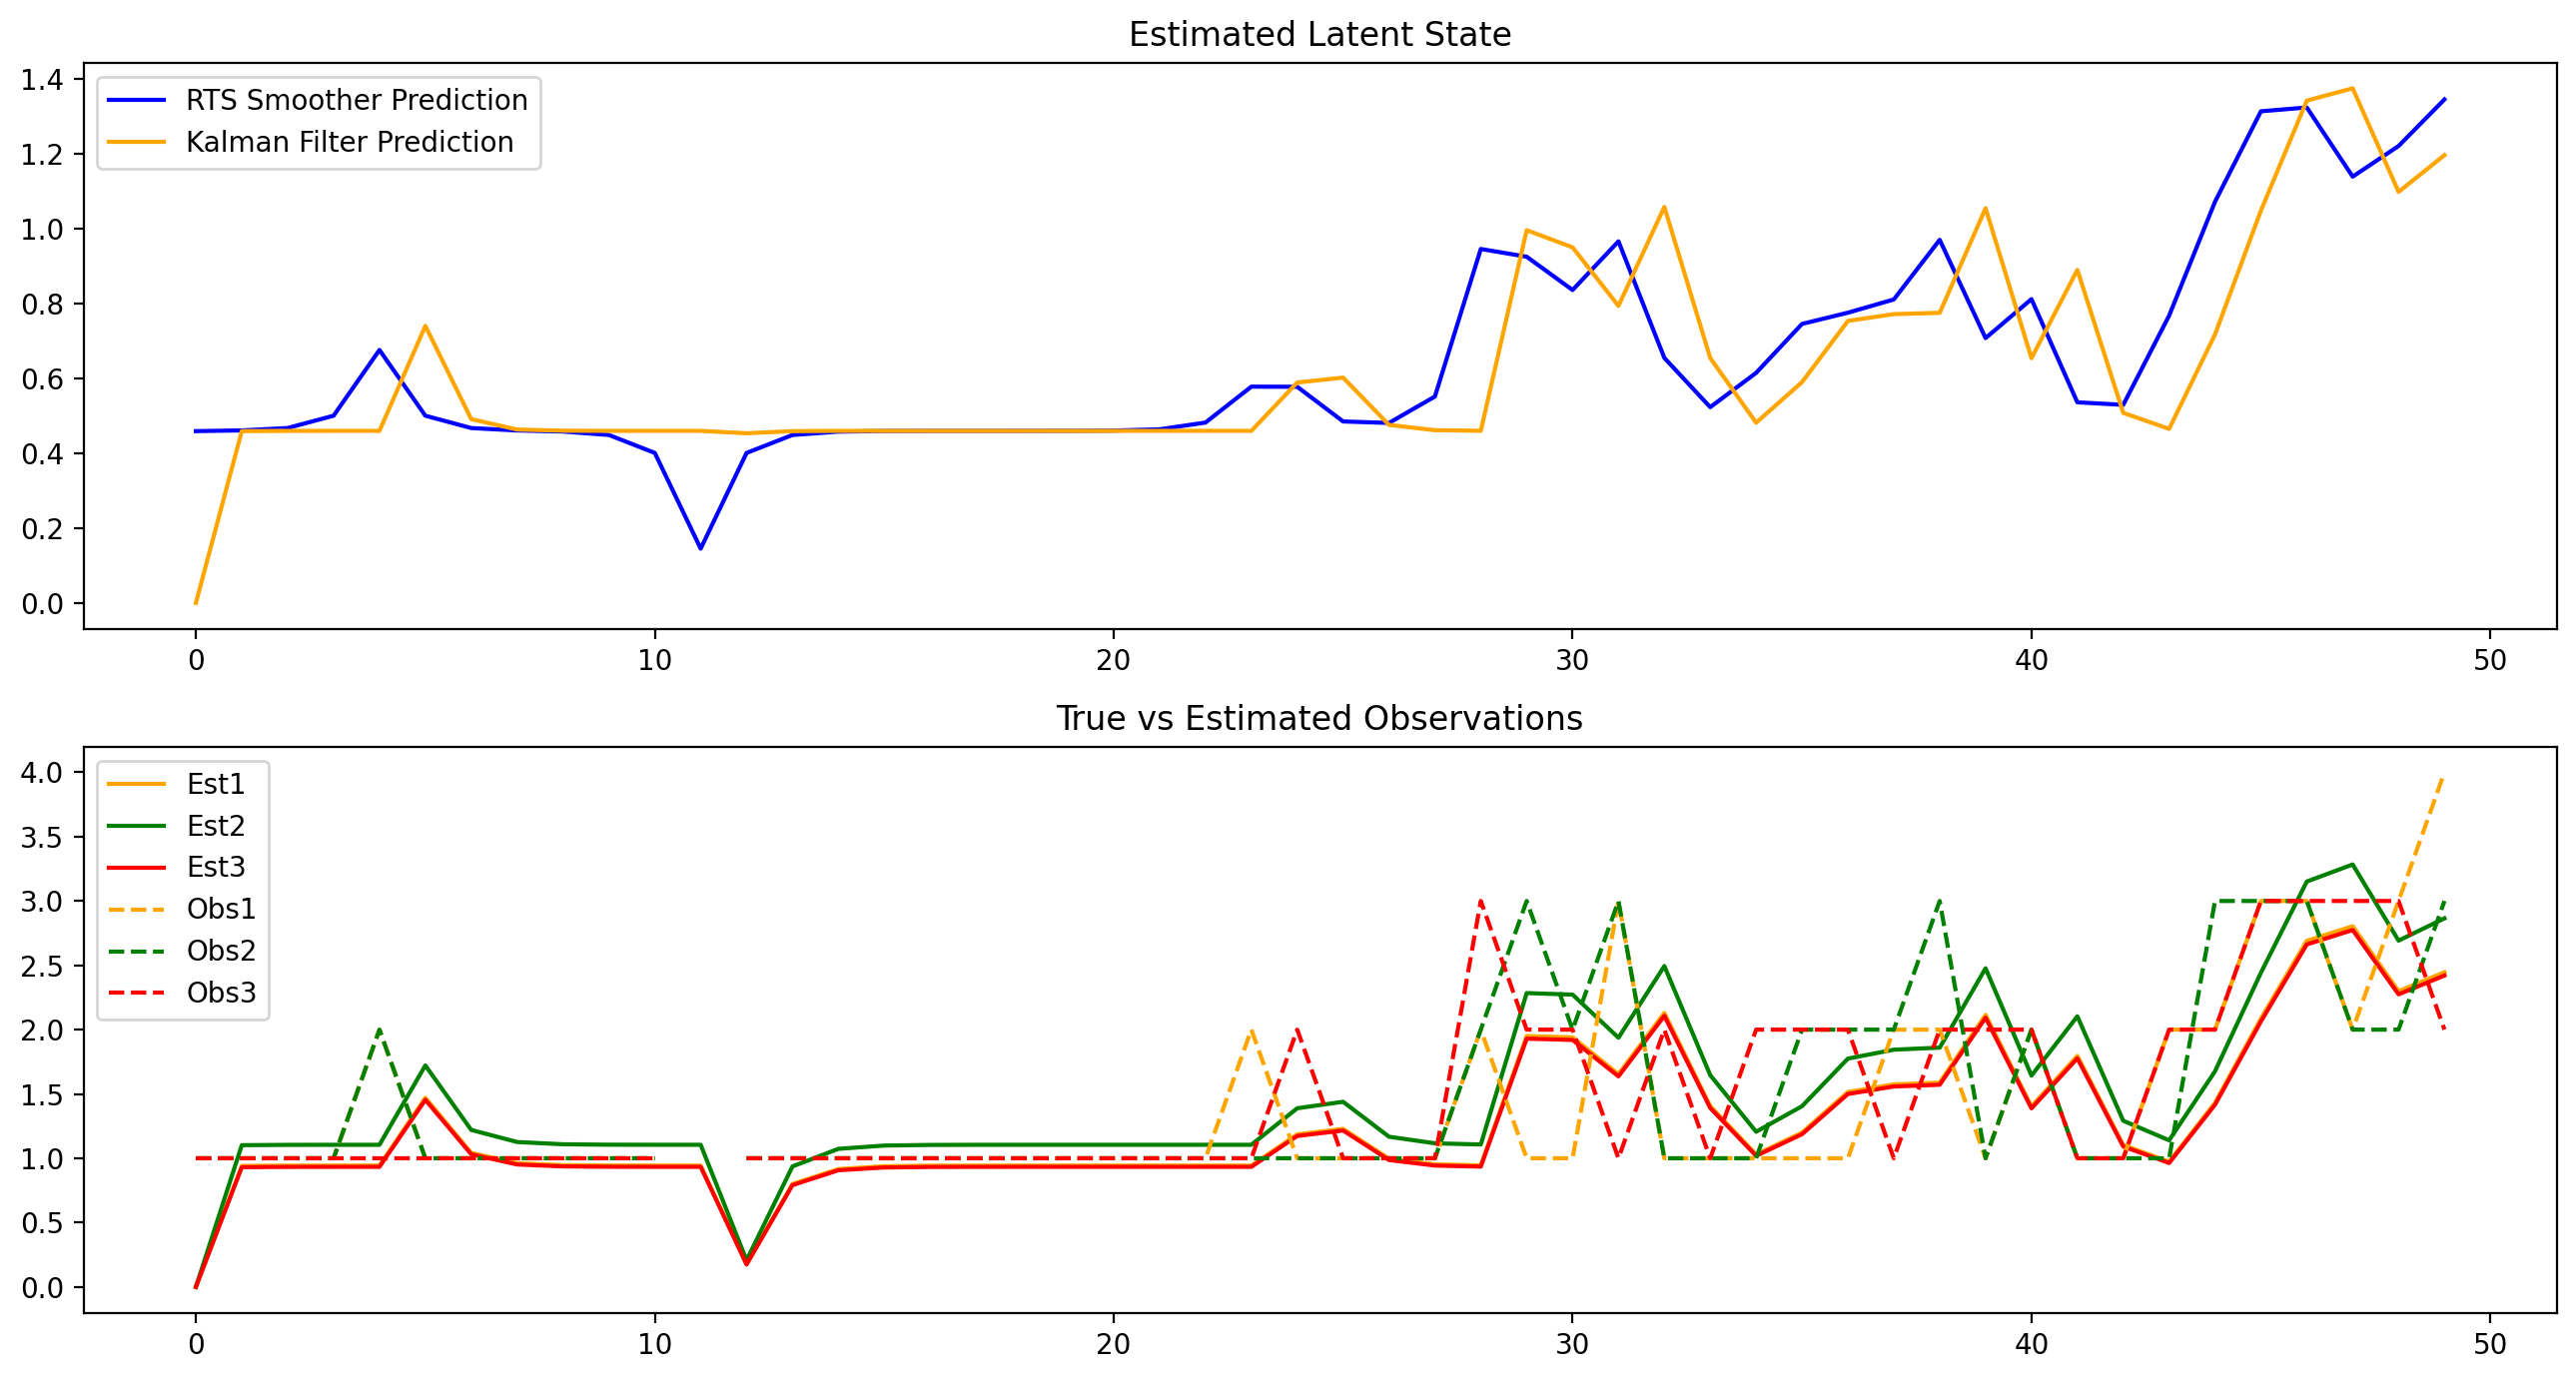

In [12]:
STUDENT = 2

F = np.array([[1]])  # Assuming no change in state


Q = np.array([[0.01]])  # Adjust the value as per your system dynamics and noise characteristics

R = np.array([[2, 0, 0],  # Covariance of the first observation
              [0, 2, 0],  # Covariance of the second observation
              [0, 0, 2]])*0.02 # Covariance of the third observation
x0 = np.array([[0]])  # Initial state estimate


observations = Y[STUDENT,:,:].T


kf = KalmanFilter(F = F, H = H, Q = Q, R = R, x0 = x0)


# Initialize arrays to hold the filtered state estimates and their covariances
n = len(observations)
x_filt = np.zeros((n, kf.n, 1)) # predictions_state
P_filt = np.zeros((n, kf.n, kf.n)) # predictions_cov
obs_filt = [np.zeros((3,1)) for _ in range(50)] # predictions_obs


for i, z in enumerate(observations):
    z = z.reshape(3, 1)

    # If the observation is missing (NaN), impute it
    if np.isnan(z).any():
        if i == 0:  # If the first observation is missing, use an arbitrary value
            z = np.array([[2], [2], [2]])
        else:  
            #z = np.dot(kf.H, x_filt[i-1]) # Otherwise, use the previous state estimate
            expected_mean = np.random.normal(x_filt[-1],P_filt[-1]) # sampling from the last observed step
            z = H @ expected_mean #from latent to observed state

    # Predict the next state
    x_pred, P_pred = kf.predict()
    x_filt[i] = x_pred
    P_filt[i] = P_pred
    obs_filt[i] = H @ x_pred

    # Update the state estimate with the current observation
    kf.update(z)
    x_filt[i] = kf.x
    P_filt[i] = kf.P

# Run the RTS smoother on the filtered estimates and get the smoothed state estimates and their covariances
x_smooth, P_smooth, K = kf.rts_smoother(x_filt, P_filt)

# Create a figure and two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 7))

# Plotting the smoothed state estimates and Kalman filter predictions on the first subplot (ax1)
ax1.plot(range(len(x_smooth)), x_smooth.reshape(len(observations),1), label='RTS Smoother Prediction', color='blue')
ax1.plot(range(len(predictions_state)), np.array(predictions_state).reshape(len(observations),1), label='Kalman Filter Prediction', color='orange')
ax1.set_title("Estimated Latent State")
ax1.legend()

# Plotting observations and estimates on the second subplot (ax2)
colors = ['orange', 'green', 'red']

# Plotting observations
for i in range(3):
    ax2.plot(np.array(obs_filt).reshape(len(observations), 3)[:, i], label=f"Est{i+1}", color=colors[i])

# Plotting estimates
for i in range(3):
    ax2.plot(observations[:,i], label=f"Obs{i+1}", linestyle="--", color=colors[i])

ax2.legend()
ax2.set_title("True vs Estimated Observations")
# Adjusting layout to prevent overlapping
plt.tight_layout()

plt.show()





## Learning Drop out

Here we will learn a model that predicts drop out from the latent state. 

We will start by using logistic regression, assuming no time dependence. 

For each student, we need the state, and a variable of drop out prediction. From here, to keep the dataset balanced, we will take all drop outs (43 Students), and take the first drop out event of each:

In [13]:
dropouts = tx[tx["event"]==1].groupby(["event", "studentID"])["meas"].first().to_frame().reset_index()
dropouts.head()

,event,studentID,meas
0,1,student1,54
1,1,student10,61
2,1,student102,54
3,1,student104,131
4,1,student11,131


From here, we need to get the indices from the measurement period (i.e. meas 131 = 50th time point), so we can pull the state at that time for each student.

In [14]:
unique_meas = np.array(list(set(tx.meas.values)))
unique_meas.sort()

idx = []
for meas in dropouts.meas:
    idx.append(np.argwhere(unique_meas == meas)[0])
dropouts["idx"] = np.array(idx)
dropouts.head()

,event,studentID,meas,idx
0,1,student1,54,20
1,1,student10,61,23
2,1,student102,54,20
3,1,student104,131,49
4,1,student11,131,49


Now we want to estimate states for each student

In [15]:
#Y[STUDENT,:,:].T
n_students = Y.shape[0]
n_time = Y.shape[2]


states = np.zeros((n_students, n_time, 1,1))
covs = np.zeros((n_students, n_time, 1,1))


for i in range(n_students):

    observations = Y[i,:,:].T
    
    
    kf = KalmanFilter(F = F, H = H, Q = Q, R = R, x0 = x0)
    predictions_state = []
    predictions_obs = []
    predictions_cov = []
    
    for z in observations:
        z = z.reshape(3,1)
        if np.isnan(z).any():# all the missing values
            if not predictions_state: #if predictions are empty, meaning that the first observation is empty i.e. the first value is nan, set z to 1,1,1
                z = np.array([2,2,2]).reshape(3,1)
            else:
                expected_mean = np.random.normal(predictions_state[-1],predictions_cov[-1]) # sampling from the last observed step
                z = H @ expected_mean #from latent to observed state
        
        predictions_dummy,prediction_dummy_cov = kf.predict()
        predictions_obs.append(H @ predictions_dummy)
        predictions_state.append(predictions_dummy)
        predictions_cov.append(prediction_dummy_cov)
        kf.update(z)

    states[i] = np.array(predictions_state)
    covs[i] = np.array(predictions_cov)



Now we have the estimated states and covariances for each student. From here, we need to extract the state out dropout for each student (that dropped out)

In [16]:
student_idx_in_Y = np.where(tx.studentID.unique() == "student10")[0][0]
dropout_idx_in_T = dropouts.iloc[student_idx_in_Y,3]

In [17]:
# state at dropout for student_id.
states[student_idx_in_Y, dropout_idx_in_T]

array([[0.68305323]])

In [18]:
# Y and tx students are ordered in the same way.
dropout_state_values = np.zeros(len(dropouts.studentID))

i = 0
for i, studentid in enumerate(dropouts.studentID):
    student_idx_in_Y = np.where(tx.studentID.unique() == studentid)[0][0]
    dropout_idx_in_T = dropouts.iloc[i,3]
    state_val_at_dropout = states[student_idx_in_Y, dropout_idx_in_T]
    dropout_state_values[i] = state_val_at_dropout.flatten()[0]
    i += 1

#### Non-dropout values.

Here, we continue with the assumption that dropout isn't anything complicated, and a high state on a given can result in a dropout. All we want to do, is sample a equal number of non-dropout event states.

As the vast majority of these states are non-dropout, we can just sample roughly 50 states and assume they are all non-dropouts. We can adjust this later on for a more refined result.

In [19]:
n_samples = 50
n_dropouts = len(dropout_state_values)

non_dropout_states = np.random.choice(states.flatten(), size=n_samples)

To see the difference between the dropout states and the non-dropout states, we can simply calculate the mean of each vector:

In [64]:
print(f"Non-dropout State Mean: {non_dropout_states.mean()}")
print(f"Dropout State Mean: {dropout_state_values.mean()}")

Non-dropout State Mean: 1.153968324153272
Dropout State Mean: 1.205350028949158


On the first iteration, these do not look good. We do see though that the dropout states are generally a little higher than the non-dropout states. This likely wont lead to great performance...


Now, all we need to do, is create an array with `n_dropout` 1s, and `n_samples` 0s.

In [66]:
ys = np.concatenate([np.ones(n_dropouts),np.zeros(n_samples)])
xs = np.concatenate([dropout_state_values, non_dropout_states])

From here, we want to train a basic logistic regression classifier that we can then attach to the output of the kalman filter estimates in order to predict the dropout

In [68]:
from statsmodels.discrete.discrete_model import Logit

In [69]:
log_model = Logit(ys,xs)
log_res = log_model.fit()
log_res.summary()

Optimization terminated successfully.
         Current function value: 0.691914
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   93
Model:                          Logit   Df Residuals:                       92
Method:                           MLE   Df Model:                            0
Date:                Wed, 28 Feb 2024   Pseudo R-squ.:               -0.002322
Time:                        16:49:32   Log-Likelihood:                -64.348
converged:                       True   LL-Null:                       -64.199
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0782      0.163     -0.478      0.632      -0.399       0.242
==============================================================================
"""

In [70]:
predicted_ys = log_res.predict(xs)
pd.crosstab(predicted_ys>0.5,ys)

col_0,0.0,1.0
row_0,,
False,50,43


It is quite poor... But keep in mind, that the states have yet to be measured correctly... Perhaps it would make sense to include the dropout within the KF too.. but then we'd need a linear mapping from the state to the dropout, which probably isn't a reasonable assumption.


Perhaps we can get better performance by assuming that a dropout is a result of cumulative negative states (i.e. the sum)

In [72]:
# Y and tx students are ordered in the same way.
dropout_state_values = np.zeros(len(dropouts.studentID))

i = 0
for i, studentid in enumerate(dropouts.studentID):
    student_idx_in_Y = np.where(tx.studentID.unique() == studentid)[0][0]
    dropout_idx_in_T = dropouts.iloc[i,3]
    state_val_at_dropout = np.sum(states[student_idx_in_Y, :dropout_idx_in_T])
    dropout_state_values[i] = state_val_at_dropout.flatten()[0]
    i += 1

to be continued... Need to sample and sum up some random samples. Potentially we just use the total sum of state for non-dropout memembers across the whole time period...

In [31]:
non_dropouts = tx[tx["event"]==0].groupby(["event", "studentID"])["meas"].first().to_frame().reset_index()
non_dropouts.head()

,event,studentID,meas
0,0,student1,8
1,0,student10,8
2,0,student100,8
3,0,student101,8
4,0,student102,8


In [32]:
unique_meas = np.array(list(set(tx.meas.values)))
unique_meas.sort()

idx = []
for meas in non_dropouts.meas:
    idx.append(np.argwhere(unique_meas == meas)[0])
non_dropouts["idx"] = np.array(idx)
non_dropouts.head()

,event,studentID,meas,idx
0,0,student1,8,0
1,0,student10,8,0
2,0,student100,8,0
3,0,student101,8,0
4,0,student102,8,0


In [45]:
import random
non_dropout_students = []
for i in range(50): # get 50 random students
    student = random.choice(list(set(non_dropouts.studentID) - set(dropouts.studentID))) # randomly select 
    non_dropout_students.append(student)

50

In [58]:
sum_non_dropout = []
for studentid in non_dropout_students:
    student_idx_in_Y = np.where(tx.studentID.unique() == studentid)[0][0] # student
    state_val_non_dropout = states[student_idx_in_Y, :] # 50 timestep state values per student, (50,1,1)
    non_dropout_states_sum = np.cumsum(state_val_non_dropout, axis=0)
    sum_non_dropout.append(non_dropout_states_sum)

`sum_non_dropout` contains 50 random students' cumulative state values for 50 weeks. 